# Исследование популярности сервиса аренды самокатов GoFast.

В вашем распоряжении данные сервиса аренды самокатов GoFast — в основных данных есть информация о пользователях из различных городов, их поездках и подписках. В данной работе наша задача проанализировать общие данные и информацию о пользователях и их поездках, узнать, какая категория пользователей (с подпиской или без нее) приносит большую помесячную выручку, а также проверить некоторые гипотезы, которые могут помочь бизнесу по аренде самокатов вырасти.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

## Шаг 1. Загрузка данных

In [24]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

In [25]:
display(users.head(10))
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [26]:
display(rides.head(15))
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [27]:
display(subscriptions.head(5))
subscriptions.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В датафреймах отображены имена пользователей, к каждому из них присвоен персональный id, далее имеется дата, время, место и продолжительность их поездок. Мы видим, оформлена ли подписка на самокаты у человека, или же он не пользуется подпиской. Вдобавок, мы можем заметить, что многие пользователи совершали по несколько поездок в течении года.
После изучения общей информации о каждом датафрейме мы можем сказать, что в данных отсутвуют пропуски и нет необходимости в их обработке или замене.

## Шаг 2. Предобработка данных

In [28]:
rides['date'] = pd.to_datetime(
    rides['date'], format='%Y-%m-%d'
) 
# приведем столбец date к типу даты pandas

In [29]:
rides['month'] = pd.DatetimeIndex(rides['date']).month #месяц поездки
print(rides.head(5))

   user_id     distance   duration       date  month
0        1  4409.919140  25.599769 2021-01-01      1
1        1  2617.592153  15.816871 2021-01-18      1
2        1   754.159807   6.232113 2021-04-20      4
3        1  2694.783254  18.511000 2021-08-11      8
4        1  4028.687306  26.265803 2021-08-28      8


In [30]:
rides['year'] = pd.DatetimeIndex(rides['date']).year #год поездки
print(rides['year'].unique())

[2021]


Как мы можем заменить, мы анализируем данные, только за 2021 год.

In [31]:
print(users.isna().sum())
print(rides.isna().sum())
print(subscriptions.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
year        0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Как видно из информации о датафреймах, пропусков в данных нет. Проверим их на наличие дубликатов.

In [32]:
print(users['user_id'].duplicated().sum()) # найдем количество дубликатов

31


In [33]:
print(users['user_id'].value_counts().head(32))

user_id
209     2
807     2
611     2
43      2
737     2
47      2
1198    2
829     2
924     2
153     2
635     2
72      2
909     2
908     2
136     2
1045    2
1237    2
127     2
659     2
307     2
1245    2
121     2
666     2
108     2
297     2
809     2
293     2
16      2
422     2
403     2
204     2
1035    1
Name: count, dtype: int64


In [34]:
users = users.drop_duplicates(subset=['user_id'], keep='first')
users = users.reset_index(drop=True)
print(users['user_id'].duplicated().sum()) # проверка

0


In [35]:
print(rides['duration'].duplicated().sum())

94


In [36]:
print(rides['duration'].value_counts().head(5))
print(len(rides['duration']))

duration
0.500000     95
25.599769     1
30.932438     1
12.061496     1
15.615504     1
Name: count, dtype: int64
18068


Как мы видим, в датафрейме есть строки с очень быстрыми поездками (близкие по продолжительности к 0). Это может означать, что некоторые пользователи по ошибке начали поездку на самокате и сразу же ее отменили. Удалим данные значения, т.к. они составляют маленький процент от всего датафрейма, и не оказывают на него сильного влияния.

In [37]:
rides = rides[(rides['duration']>0.5)]
rides = rides.reset_index(drop=True)

In [38]:
print(rides['duration'].duplicated().sum()) #проверка
print(len(rides['duration']))

0
17973


В данной части работы мы выявляли пропуски и дубликаты в исходных датафреймах. Исследовали данные, только за 2021 год. Как оказалось, пропусков у нас не обнаружено, а дубликаты имелись. В user_id мы удалили все дубликаты и оставили только первые встречающиеся значения. Также, было очень много поездок по продолжительности очень близкими к 0 и т.к. строки с этими поездками и их параметры скорее аномальны, мы убрали их из нашего датафрейма.

## Шаг 3. Исследовательский анализ данных

**Частота встречаемости городов:**

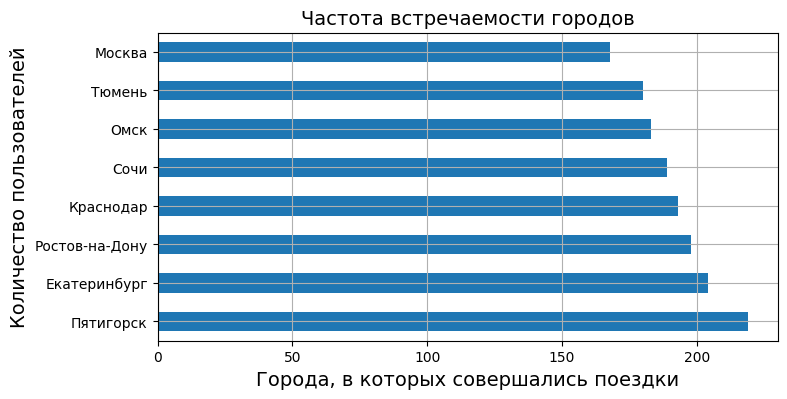

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object


In [39]:
users['city'].value_counts().plot.barh(grid=True, figsize=(8, 4))
plt.xlabel('Города, в которых совершались поездки', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.title('Частота встречаемости городов', fontsize=14)
plt.show()
print(users['city'].describe())

In [40]:
print(users['city'].value_counts())

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


Как мы видим из данных выше, во всех 8 городах примерно в равной мере люди любят кататься на самокатах, но больше всего их используют в Пятигорске, а именно 219 пользователей, в то время как в Москве меньше всего - 168.

**Соотношение пользователей с подпиской и без подписки:**

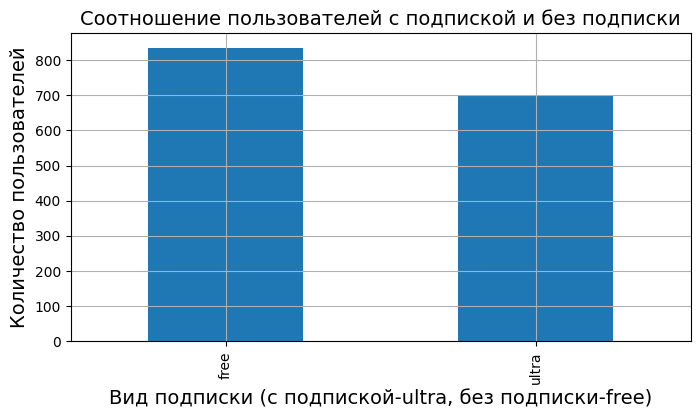

count     1534
unique       2
top       free
freq       835
Name: subscription_type, dtype: object
subscription_type
free     835
ultra    699
Name: count, dtype: int64


In [41]:
users['subscription_type'].value_counts().plot.bar(grid=True, figsize=(8, 4))
plt.xlabel('Вид подписки (с подпиской-ultra, без подписки-free)', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.title('Соотношение пользователей с подпиской и без подписки', fontsize=14)
plt.show()
print(users['subscription_type'].describe())
print(users['subscription_type'].value_counts())

Построим круговую диаграмму, чтобы посмотреть соотношение двух групп пользователей.

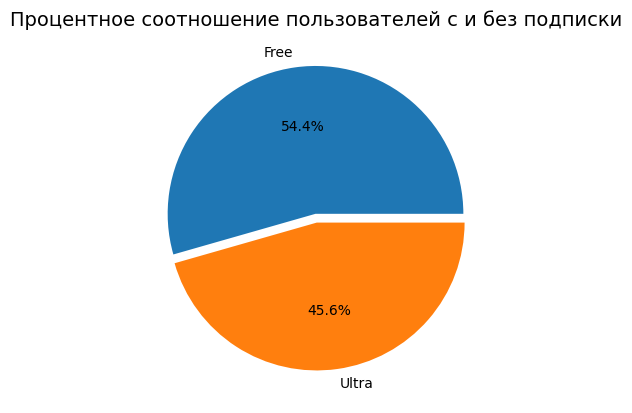

In [42]:
labels = 'Free', 'Ultra'
sizes = [835, 699]
fig1, ax1 = plt.subplots()
explode = [0.03, 0.03]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode)
plt.title('Процентное соотношение пользователей с и без подписки', fontsize=14)
plt.show()

Людей, которые используют подписку для поездок на самокате составляет 699 человек, в то время как катающихся бесплатно 835 пользователей. Из круговой диаграммы видно, что большинсво людей, а именно 54.4 % из общего количества пользователей, предпочитают кататься на самокатах без подписки.

**Возраст пользователей:**

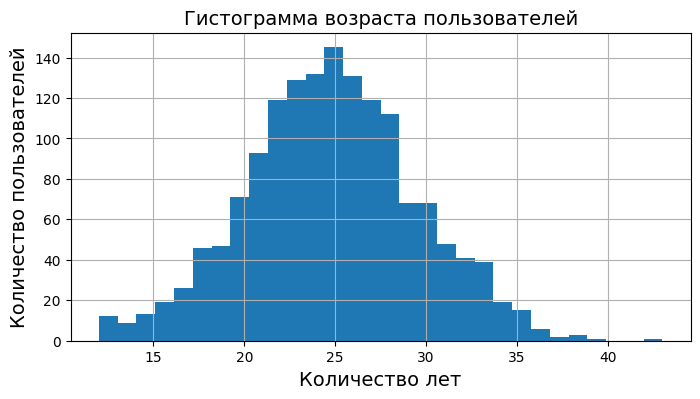

In [43]:
users['age'].hist(bins=30, grid=True, figsize=(8, 4))
plt.xlabel('Количество лет', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.title('Гистограмма возраста пользователей', fontsize=14)
plt.show()

In [44]:
print(users['age'].describe())
print(users['age'].value_counts())

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64
age
25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: count, dtype: int64


Возраст людей варьируется от 12 до 43 лет. Как и ожадалось из гистограммы мы видим, что молодые люди в возрасте от 22-28 чаще используют самокат как средство транспорта, нежели люди среднего возраста. Больше всего пользователей, а именно 145 человек, 25-летнего возраста. И всего 1 человек 39-и и 43-летнего возраста.

**Расстояние, которое пользователь преодолел за одну поездку:**

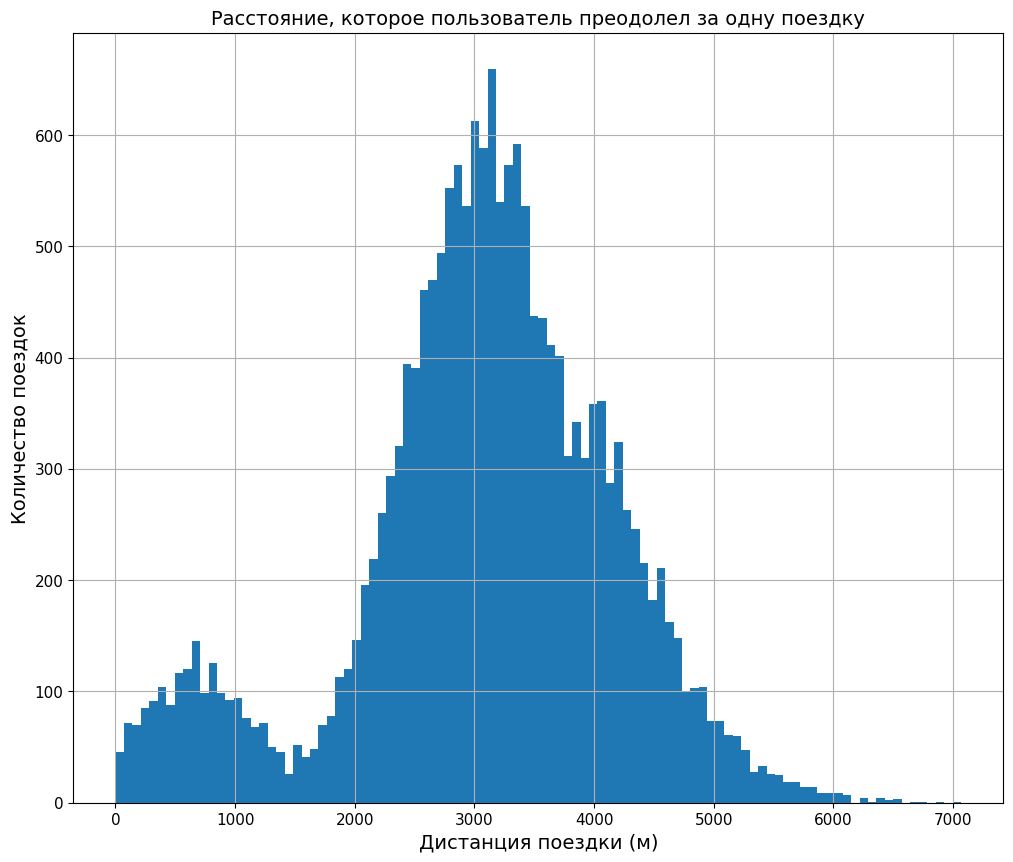

In [45]:
rides['distance'].plot(
    kind='hist',
    bins=100,
    figsize=(12,10),
    fontsize=11,
    grid=True
)
plt.xlabel('Дистанция поездки (м)', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Расстояние, которое пользователь преодолел за одну поездку', fontsize=14)
plt.show() 

В данной гистограмме у нас присутсвуют два пиковых значения на распределении. Это можно обяснить тем, что скорее всего у нас есть два вида пользователей самокатов. Те, кто используют их как непостредсвенно средство передвижения из пунка А в пункт Б на далекие расстояния. И те, кто катается на самокатах ради развлечения, а также возможно до ближайщих точек от дома, например магазин.

In [46]:
print(rides['distance'].describe())

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64


Как мы видим из графика, самокаты, как средство передвижения, используют как на маленькие так и на большие дистанции. Подавляющее большинство пользователей совершают поездки в среднем от 2.500 до 3.700 метров.

**Продолжительность поездок пользователей:**

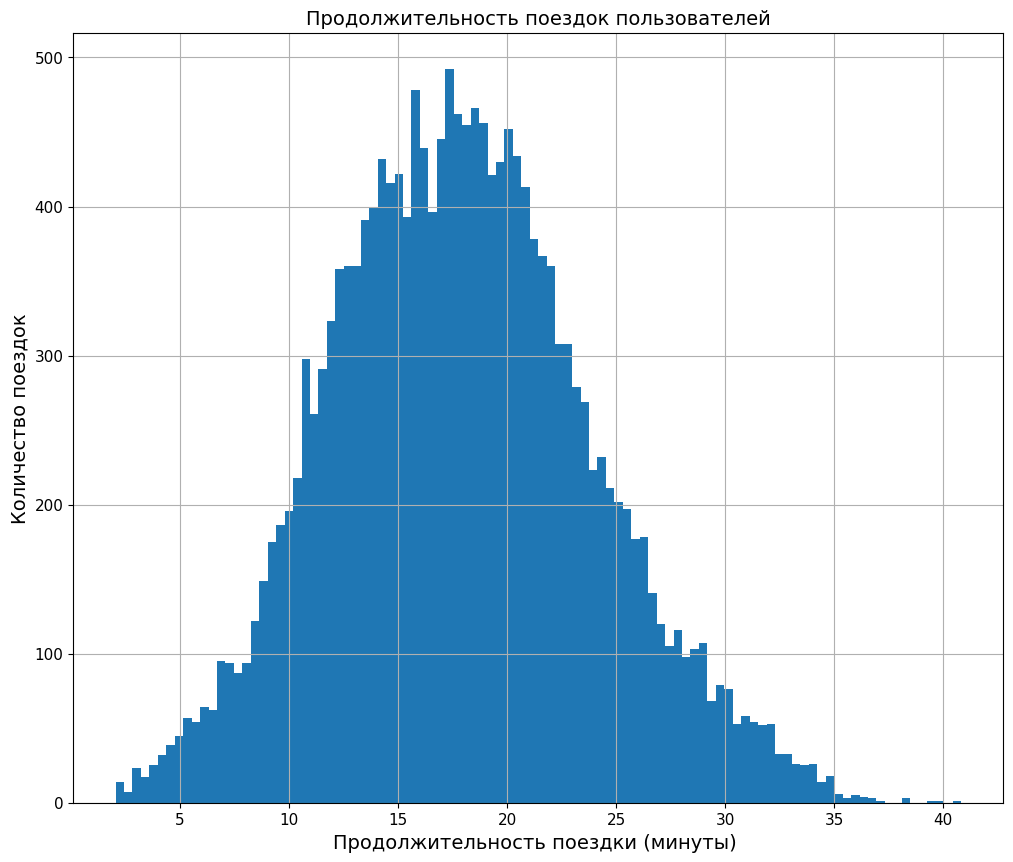

In [47]:
rides['duration'].plot(
    kind='hist',
    bins=100,
    figsize=(12,10),
    fontsize=11,
    grid=True
)
plt.xlabel('Продолжительность поездки (минуты) ', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Продолжительность поездок пользователей', fontsize=14)
plt.show() 

In [48]:
print(rides['duration'].describe())

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64


Как мы видим из гистограммы, промежуток продолжительности поездок составляет от 2 до 40 минут, а в среднем, большинство людей совершают поездки продолжительностью от 13 до 21 минуты.

## Шаг 4. Объединение данных

In [49]:
data_users_rides = users.merge(rides, on='user_id')
data_users_rides.head(5) #объединяем датафреймы в один датафрейм

,user_id,name,age,city,subscription_type,distance,duration,date,month,year
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,2021
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2021
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,2021
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2021
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,2021


In [50]:
data_total = data_users_rides.merge(subscriptions, on='subscription_type')
data_total.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,2021,6,0,199


Проверяем полученную таблицу:

In [51]:
print('Количество строк таблицы users: ', len(users))
print('Количество строк таблицы rides: ', len(rides))
print('Количество строк таблицы subscriptions: ', len(subscriptions))
print('Количество строк после объединения: ',len(data_total))

Количество строк таблицы users:  1534
Количество строк таблицы rides:  17973
Количество строк таблицы subscriptions:  2
Количество строк после объединения:  17973


In [52]:
print(data_total.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
year                 0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Все хорошо, после объединения все строчки остались на месте и пропуски не появились.
Далее cоздадим ещё датафрейм с данными о пользователях с подпиской и без нее

In [53]:
data_users_sub = data_total.query('subscription_type=="ultra"') #cоздайем ещё датафрейм с данными о пользователях с подпиской
data_users_nosub = data_total.query('subscription_type=="free"') #cоздайем ещё датафрейм с данными о пользователях без подписки

In [54]:
print(len(data_users_rides))
print(len(data_users_sub))
print(len(data_users_nosub)) #проверяем, чтобы ничего не потерялось

17973
6500
11473


Поездок пользователей без подписки почти в 2 раза больше, нежели с ней.

**Рассмотрим информацию о пройденом расстоянии пользователей с подпиской и без нее:**

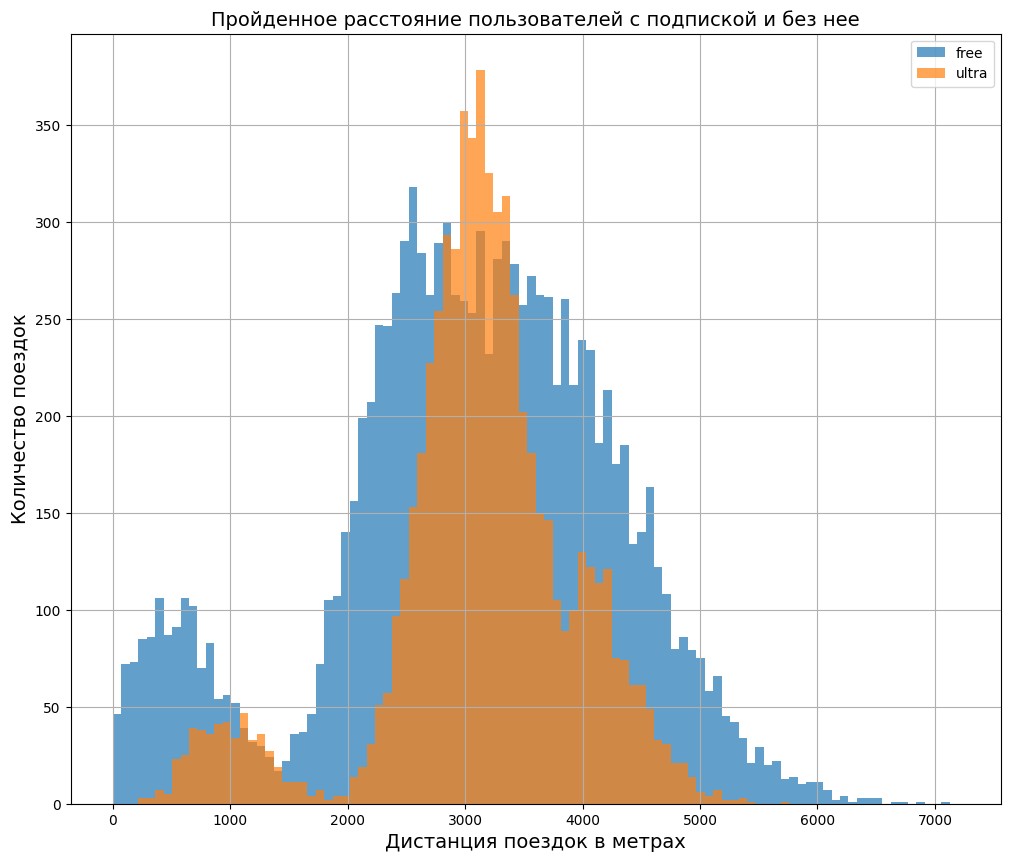

In [55]:
ax = data_users_nosub.plot(
    kind='hist',
    y='distance',
    range=(0, 7200),
    figsize=(12,10),
    bins=100,
    alpha=0.7,
    label='free', # гистограмма по дальности поездок для пользователей без подписки
)
data_users_sub.plot(
    kind='hist',
    y='distance',
    range=(0, 7200),
    figsize=(12,10),
    bins=100,
    alpha=0.7,
    label='ultra',
    ax=ax,
    grid=True,
    legend=True, 
) 
plt.xlabel('Дистанция поездок в метрах', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Пройденное расстояние пользователей с подпиской и без нее', fontsize=14)
plt.show() # построим общую гистограмму по дальности поездок для пользователей с подпиской и без нее

In [56]:
data_users_sub['distance'].describe() #данные расстояния о пользователях с подпиской

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [57]:
data_users_nosub['distance'].describe() #данные расстояния о пользователях без подписки

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

Как мы видим из данных графиков, пользователи без подписки катаются на самокатах на более длительные расстояния, нежели пользователи с подпиской. Также, люди без подписки, более склонны и любят совершать проездки на самокатах на маленькие расстояния, скорее всего ради развлечения. А так, в среднем, обе группы людей, у которых оформляена подписка и у которых ее нет, совершают поездки приблизительно на расстояние 3.100 метров.

**Рассмотрим информацию о времени поездок пользователей с подпиской и без нее:**

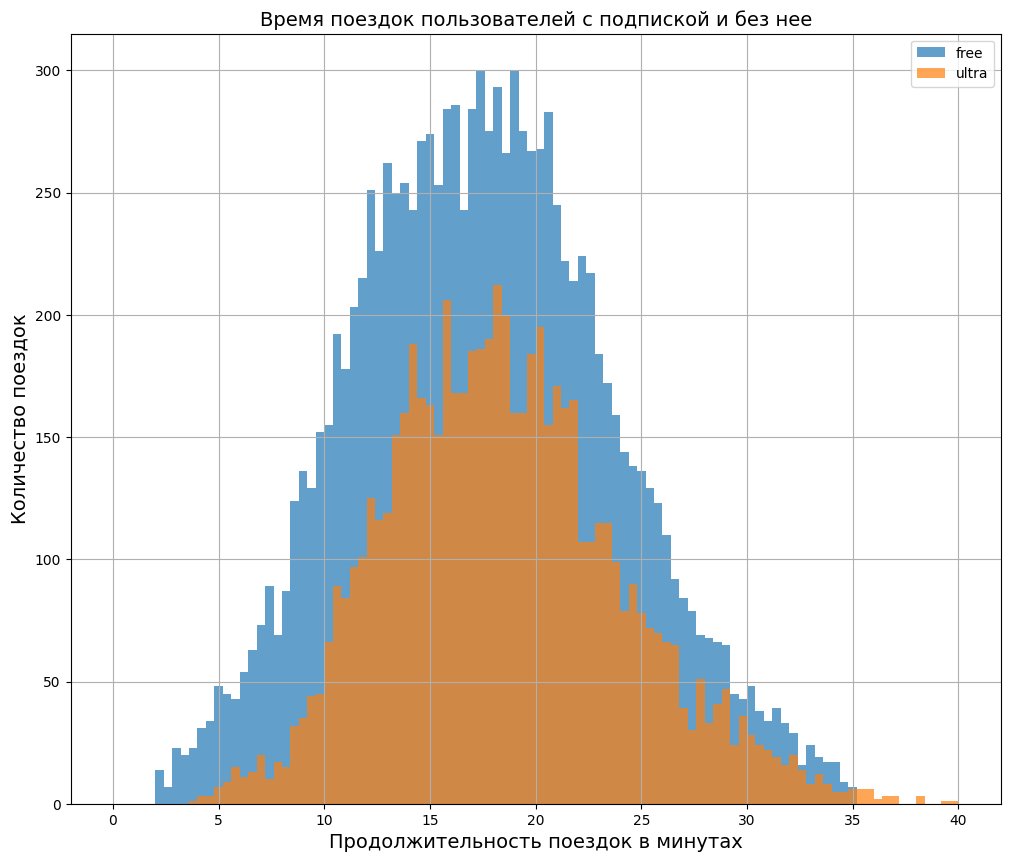

In [58]:
ax = data_users_nosub.plot(
    kind='hist',
    y='duration',
    range=(0, 40),
    figsize=(12,10),
    bins=100,
    alpha=0.7,
    label='free', # гистограмма о продолжительности поездок для пользователей без подписки
)
data_users_sub.plot(
    kind='hist',
    y='duration',
    range=(0, 40),
    figsize=(12,10),
    bins=100,
    alpha=0.7,
    label='ultra',
    ax=ax,
    grid=True,
    legend=True, 
) 
plt.xlabel('Продолжительность поездок в минутах', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Время поездок пользователей с подпиской и без нее', fontsize=14)
plt.show() # построим общую гистограмму о продолжительности поездок для пользователей с подпиской и без нее

In [59]:
data_users_sub['duration'].describe() #данные о времени поездок у пользователей с подпиской

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [60]:
data_users_nosub['duration'].describe() #данные о времени поездок у пользователей без подписки

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

На данном объединенном графике видно, что количество поездок совершенных пользователями без подписки больше, чем с подпиской. Также, у обоих катагорий пользователей примерно одинаковая средняя продолжительность поездки 17-18 минут.

## Шаг 5. Подсчёт выручки

In [61]:
import numpy as np

# каждое значение из столбца duration округляем с помощью «потолка»: 
data_total['duration'] = np.ceil(data_total['duration'])

In [62]:
#cоздаем датафрейм с агрегированными данными
data_total_aggregated = data_total.groupby(['user_id', 'month'])\
                     .agg({'distance':'sum', 'duration':['sum', 'count'], 'subscription_type':'first',
                           'minute_price':'first', 'start_ride_price':'first', 'subscription_fee':'first'})

# переименуем названия столбцов
data_total_aggregated.columns = ['sum_distance', 'sum_duration', 'count_rides', 
                                 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']

In [63]:
data_total_aggregated.head()

sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   

               minute_price  start_ride_price  subscription_fee  
user_id month                                                    
1       1                 6                 0               199  
        4                 6                 0               199  
        8                 6                 0               199  
        10                6                 0               199  
        11                6                 0               199

Добавим столбец с помесячной выручкой

In [64]:
data_total_aggregated['monthly_revenue'] = data_total_aggregated['start_ride_price']\
                     * data_total_aggregated['count_rides'] + data_total_aggregated['minute_price']\
                     * data_total_aggregated['sum_duration'] + data_total_aggregated['subscription_fee']

In [65]:
data_total_aggregated.head()

sum_distance  sum_duration  count_rides subscription_type  \
user_id month                                                              
1       1       7027.511294          42.0            2             ultra   
        4        754.159807           7.0            1             ultra   
        8       6723.470560          46.0            2             ultra   
        10      5809.911100          32.0            2             ultra   
        11      7003.499363          56.0            3             ultra   

               minute_price  start_ride_price  subscription_fee  \
user_id month                                                     
1       1                 6                 0               199   
        4                 6                 0               199   
        8                 6                 0               199   
        10                6                 0               199   
        11                6                 0               199   

               monthly_revenue  
user_id month                   
1       1                451.0  
        4                241.0  
        8                475.0  
        10               391.0  
        11               535.0

В данной части работы мы создали датафрейм с агрегированными данными о поездках, нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, и в итоге выявляли выручку от всех пользователей.

## Шаг 6. Проверка гипотез

**6.1**

Cуществует время на поездки групп пользователей: с платной подпиской (sub) и без подписки (nosub). Проверим гипотезу о том, что пользователи с подпиской тратят больше времени на поездки. Нулевая гипотеза: средние значения времени пользователей из двух групп равны. Альтернативная гипотеза: среднее значение времени пользователей с подпиской больше, чем среднее значение времени пользователей без подписки

In [66]:
# задаём уровень значимости
# если p-value окажется меньше него, отвергнем гипотезу
alpha = 0.05

# время первой группы пользователей (с подпиской)
sub = data_users_sub['duration'] 

# время второй группы пользователей (без подписки)
nosub = data_users_nosub['duration'] 

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(sub, nosub, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Выведем средние значения продолжительности поездок для пользователей с подпиской и без нее

In [67]:
print('Средняя продолжительность поездок пользователей с подпиской',data_users_sub['duration'].mean())
print('Средняя продолжительность поездок пользователей без подпиской',data_users_nosub['duration'].mean())

Средняя продолжительность поездок пользователей с подпиской 18.54198516280583
Средняя продолжительность поездок пользователей без подпиской 17.530771268800226


Полученное значение p-value меньше заданного уровня значимости и стремится к 0, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

**6.2**

В данной задаче нам нужно определить, можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? В связи с этим формулируем гипотезы. Нулевая гипотеза: расстояние одной поездки на самокате равно 3130 метров. Альтернативная гипотеза же заключается в том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 метров.

In [68]:
distance_sub = data_users_sub['distance'] 
distance_value = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    distance_sub, 
    distance_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Т.к. значение p-value больше уровня значимости, то нулевая гипотеза не отвергается. Из этого следует, что расстояние значимо не превышает 3130 метров, и находится близко к этому значению.

**6.3**

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Нулевая гипотеза: средние значения помесячной выручки пользователей из двух групп равны. Альтернативная гипотеза: среднее значение помесячной выручки пользователей с подпиской больше, чем среднее значение помесячной выручки пользователей без подписки

In [69]:
data_total_aggregated_sub = data_total_aggregated.query('subscription_type=="ultra"')
data_total_aggregated_nosub = data_total_aggregated.query('subscription_type=="free"')

In [70]:
# задаём уровень значимости
# если p-value окажется меньше него, отвергнем гипотезу
alpha = 0.05

# помесячная выручка первой группы пользователей (с подпиской)
sub_monthly_revenue = data_total_aggregated_sub['monthly_revenue'] 

# помесячная выручка второй группы пользователей (без подписки)
nosub_monthly_revenue = data_total_aggregated_nosub['monthly_revenue']  

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(sub_monthly_revenue, nosub_monthly_revenue, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


In [71]:
print('Среднее значение выручки пользователей с подпиской',data_total_aggregated_sub['monthly_revenue'].mean())
print('Среднее значение выручки пользователей без подпиской',data_total_aggregated_nosub['monthly_revenue'].mean())

Среднее значение выручки пользователей с подпиской 362.7921906022502
Среднее значение выручки пользователей без подпиской 329.3326437121324


Полученное значение p-value меньше заданного уровня значимости и стремится к 0, поэтому можно отвергнуть нулевую гипотезу. Существует большая вероятность, что помесячная выручка от пользователей с подпиской значительно больше, чем от пользователей без подписки. Это также подтверждается выведенными средними значениями каждой категории.

**6.4**

В данной задаче, нам нужно определить повлияет ли обновление сервера, с которыми взаимодействует мобильное приложение, на изменение количества обращений в техподдержку.

В данном тесте для проверки гипотезы необходимо использовать 'Гипотезу о равенстве средних для зависимых (парных) выборок'. Как мы видим из задания нам нужно проверить нулевую гипотезу а именно, равно ли среднее количество обращений до обновления сервера и после него. Альтеранативная гипотеза же, что среднее количество обращений изменится. Выборки в этом случае будут зависимыми, или парными.

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок, нам необходимо применим метод scipy.stats.ttest_rel( ) для проведения t-теста парных выборок. Ему передаем два параметра: набор данных до обновления и после него.

Если окажется что значение p-value будет меньше заданного уровня значимости, то мы отвергаем нулевую гипотезу о равенстве обращений в техподдержку до и после обновления. Это означает, что из-за обновления сервера количество обращений в техподдержку значительно изменилось. Если же окажется, что значение p-value будет больше заданного уровня значимости, то нулевую гипотезу мы не отвергаем и после обновления количество обращений в поддержку не поменялось.

## Шаг 7. Общий вывод

В данной работе мы рассматривали архив данных популярного сервиса аренды самокатов GoFast. Нам передали данные за 2021 год о некоторых пользователях из нескольких городов, а также об их поездках. Нашей задачей было проанализировать исходные данные и проверить некоторые гипотезы, которые могут помочь бизнесу по аренде самокатов вырасти.  
  
Сначала, мы изучили общую информацию трех различных датасетов и выполнили предобработку данных. Сервисом, чтобы совершать поездки по городу, можно пользовататься без подписки и с подпиской. У данных категорий различный тариф. После изучения мы увидели, что в данных отсутвуют пропуски и не было необходимости в их обработке или замене. Вдобавок определили, что в данных присутствуют дубликаты и аномалии и впоследствии преобразовали их или же удалили, т.к. они не оказывали сильного влияния на иследование. Добавили несколько столбцов а также преобразовали тип данных в интересующем нас столбце с датой поездки.  
  
Далее нашей задачей было описать и визуализировать общую информацию о пользователях и поездках, такую как:  
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

После проведения исследовательского анализа данных мы выявили, что самокатами, как средство передвижения используют в 8 городах примерно в равной мере, но больше всего любителей самокатов в Пятигорске (219 пользователей), а меньше всего в Москве (168 пользователей). Людей, оформивших подписку в мобильном приложении GoFast меньше, чем людей катающихся без нее. Отношение 45.6% к 54.4% соответсвенно от общего числа. Возраст же различный и варьируется от 12 до 43 лет. Но все же подавляющее число молодых людей, в возрасте от 22 до 28, больше пользуются самокатами как свое средство передвижения. Пик составляют пользователи 25-и лет (145 человек). Люди использую самокаты как на маленькие расстояния так и на большие аж до 7 км. Также мы заметили на гистограмме расстояния два пика. Скорее всего у нас есть 2 сегмента пользователей. Те, кто используют самокат как транспорт, например от дома до метро или от дома до работы (то есть из точки А в точку Б, которые находятся друг от друга на большом расстоянии) и те, кто катаются на самокатах в виде развлечения или же до ближайшего магазина около дома (то есть расстояния при этом  незначительные). Продолжительность поездок же составляет от 2 до 40 минут, но большинство людей совершают поездки  от 13 до 21 минуты.

После нашей задачей было объедините все данные о пользователях, поездках и подписках в один датафрейм, создать ещё датафреймы c данными о пользователях без подписки и с ней, визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий, и главное подсчитать выручку, для того чтобы определить являются ли пользователи с подпиской более выгодными для компании или же подписка никак не влияет.

Как оказалось, люди без подписки совершали поездки намного чаще, чем с ней. Также из построенных нами гистограмм видно, что пользователи без подписки хоть и катаются на самокатах на более длительные дистанции, но также у них есть бОльшая доля людей склонных к поездкам и на маленькие расстояния, нежели у пользователей с подпиской. Но в среднем, обе категории людей, совершают поездки приблизительно на расстояние 3.100 метров. Также, у обоих катагорий пользователей примерно одинаковая средняя продолжительность поездки 17-18 минут.

Далее мы создали датафрейм с агрегированными данными о поездках, нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, и в итоге выявляли выручку от всех пользователей, воспользовавшись информацией об условиях оплаты для подписчиков и тех, у кого нет подписки.

Конечно же, мы ответили на гипотезы поставленные перед нами:
1. В первой гипотезе нам нужно было определить, тратят ли пользователи с подпиской больше времени на поездки? Как оказалось, после проверки гипотезы у нас есть все основания говорить, что пользователи с подпиской тратят больше времени на поездки (что также подтверждается выведенными средними значения продолжительности поездок для пользователей с подпиской и без нее).
2. Во второй гипотезе мы должны были убедиться, можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Как мы выяснили, расстояние значимо не превышает 3130 метров, и находится близко к этому значению.
3. В третьей гипотезе мы рассуждали над тем, что будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. И после всех вычислений мы пришли к выводу, что помесячная выручка от пользователей с подпиской значительно больше, чем от пользователей без подписки (это также подтверждается выведенными средними значениями каждой категории).
4. В четвертой гипотезе нам был задан вопрос, какой тест вам понадобился бы для проверки гипотезы о том, что после обновления сервера технической командой, количество обращений в техподдержку значимо снизится. Мы определили, что данные выборки зависимые. И в связи с этим следует, что необходимо использовать метод ttest_rel( ) из библиотеки scipy.stats для проведения t-теста парных выборок.   
   
В итоге, после построения всех графиков, изучения получившихся данных и ответа на поставленные нам гипотезы мы можем сделать вывод, что пользователи с подпиской являются более выгодными для компании нежели пользователи без нее.   
Хоть и обе группы людей тратят примерно одинаковое время на совершение поездок, но все же люди с подпиской тратят немного больше времени (18.54 минуты в противовес 17.53), что конечно же сказывается на выручке, полученной от них, т.к. выручка напрямую зависит от времени использования самоката. Также, хоть и обе категории людей проезжают примерно одинаковое среднее расстояние, но у пользователей с подпиской не такой большой разброс значений в пройденном расстоянии и среднее этих значений значимо не превышает 3130 метров (что является оптимальным с точки зрения износа самоката). Также необдуманные или маленькие по дальности расстояния чаще совершаются людьми без подписки.
Ну и конечно в итоге у нас получилось , что среднее значение выручки полученной от пользователей с подпиской больше, нежели без подписки. И значит увеличение числа людей, оформляющих подписку перед поездкой на самокате, принесет компании больше прибыли.

В дальнейшем, я бы посоветовала отобрать категории городов, где прибыль больше, а где меньше, чем в других и обратить внимание на города с меньшей прибылью. Выявить факторы, которые могут влиять на меньшую популярность самокатов в этих городах и попытаться ее увеличить. Также можно добавить категории поездок, например такие как 'на работу', 'прогулка', 'до метро' и т.д. Это даст нам более понятную картину, в каких целях люди чаще всего используют самокаты, и покажет нам катеории людей, которые катаются на далекие и на маленькие расстояния. В добавок, можно посмотреть какой возраст людей приносит больше прибыли а какой меньше, и попытаться привлечь к прогулкам на самокате больше людей из той категории, которые меньше. В будущем также можно проследить, как сезон года влияет на использование самокатов и на выручку компании.